
## 1 Ajuste del learning rate y batch size



MNIST: resultados previos
MLP inicial: MLP con una capa oculta de 800 RELUs, batch size 16, 10 épocas; en test
Mejor arquitectura: una capa oculta de 800 RELUs, en val, en test ( modelo val)
Inicialización: librerías, semilla, lectura de MNIST y partición train-val-test

In [2]:
!pip install keras_tuner
!pip install keras
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner
keras.utils.set_random_seed(23); input_dim = 784; num_classes = 10
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
      M = keras.Sequential()
      M.add(keras.Input(shape=(784,)))
      M.add(keras.layers.Dense(units=800, activation='relu'))
      M.add(keras.layers.Dense(10, activation='softmax'))
      learning_rate = hp.Float("lr", min_value=0.0015, max_value=0.0019)
      opt = keras.optimizers.Adam(learning_rate=learning_rate)
      M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
      return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
      bs = hp.Int("batch_size", 64, 256, step=2, sampling="log")
      early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
      kwargs['callbacks'].append(early_cb)
      return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)


In [ ]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=3,
 overwrite=True, directory="/tmp", project_name="MNIST")


In [ ]:
tuner.search(x_train, y_train, (x_val, y_val))

Trial 3 Complete [00h 00m 50s]
val_accuracy: 0.984499990940094

Best val_accuracy So Far: 0.9848999977111816
Total elapsed time: 00h 02m 13s


In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
lr: 0.0016787335100293622
batch_size: 256
Score: 0.9848999977111816


In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.07354
Precisión: 98.29%


Experimento (cont.): iteraciones adicionales con train_val y evaluación en test

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=10, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.06979
Precisión: 98.40%


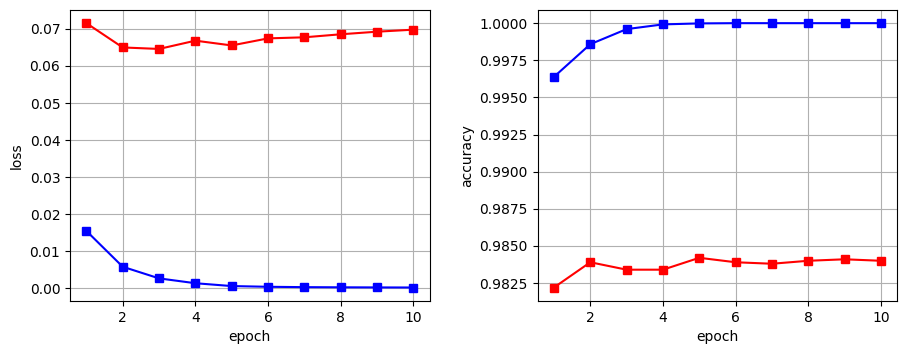

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

## 2 Planificadores

In [ ]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner
keras.utils.set_random_seed(23); input_dim = 784; num_classes = 10
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]

MyHyperModel: tras pruebas informales, exploramos learning rate próximo a 0.0017 y batch size de 64, 128 o 256



In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(784,)))
    M.add(keras.layers.Dense(units=800, activation='relu'))
    M.add(keras.layers.Dense(10, activation='softmax'))
    learning_rate = hp.Float("lr", min_value=0.0015, max_value=0.0019)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
    bs = hp.Int("batch_size", 64, 256, step=2, sampling="log")
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
    kwargs['callbacks'].append(early_cb)
    return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)

In [ ]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=10,
 overwrite=True, directory="/tmp", project_name="MNIST")

In [ ]:
tuner.search(x_train, y_train, (x_val, y_val))


Trial 10 Complete [00h 00m 35s]
val_accuracy: 0.9851999878883362

Best val_accuracy So Far: 0.9853000044822693
Total elapsed time: 00h 06m 28s


In [ ]:
tuner.results_summary(num_trials=1)


Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
lr: 0.0015819407618400422
batch_size: 256
Score: 0.9853000044822693


In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.09237
Precisión: 98.37%


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=10, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')


Loss: 0.08533
Precisión: 98.36%


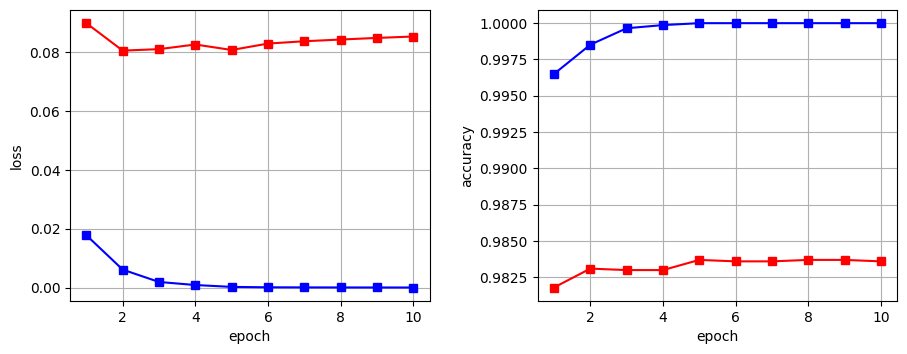

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s')
ax.plot(xx, H.history['val_loss'], color='r', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s');

## Ejercicio: realiza un experimento similar al de MNIST con Fashion-MNIST

In [3]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner
keras.utils.set_random_seed(23); input_dim = 784; num_classes = 10
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
      M = keras.Sequential()
      M.add(keras.Input(shape=(784,)))
      M.add(keras.layers.Dense(units=800, activation='relu'))
      M.add(keras.layers.Dense(10, activation='softmax'))
      learning_rate = hp.Float("lr", min_value=0.00006, max_value=0.00026)
      opt = keras.optimizers.Adam(learning_rate=learning_rate)
      M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
      return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
      bs = hp.Int("batch_size", 128, 256, step=2, sampling="log")
      early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
      kwargs['callbacks'].append(early_cb)
      return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)

In [6]:
tuner = keras_tuner.BayesianOptimization(
  MyHyperModel(), objective="val_accuracy", max_trials=3,
  overwrite=True, directory="/tmp", project_name="Fashion-MNIST")

In [7]:
tuner.search(x_train, y_train, (x_val, y_val))

Trial 3 Complete [00h 00m 55s]
val_accuracy: 0.8906000256538391

Best val_accuracy So Far: 0.8921999931335449
Total elapsed time: 00h 02m 39s


In [8]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/Fashion-MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
lr: 0.0001777305410740327
batch_size: 128
Score: 0.8921999931335449


In [9]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.3366
Precisión: 88.38%


Experimento (cont.): iteraciones adicionales con train_val y evaluación en test


In [10]:
opt = keras.optimizers.Adam(learning_rate=0.00015)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=20, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.3099
Precisión: 89.53%


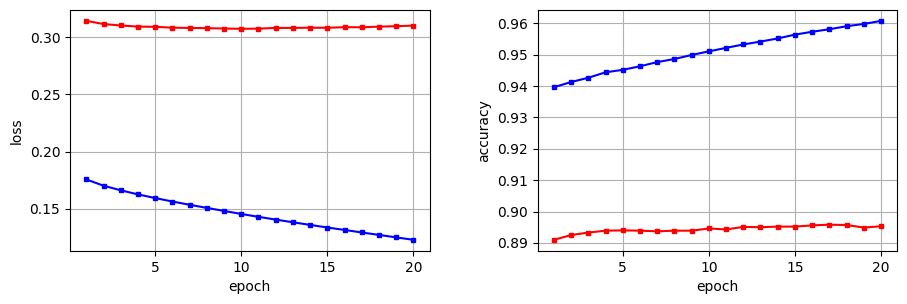

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s', markersize=3)
ax.plot(xx, H.history['val_loss'], color='r', marker='s', markersize=3)
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s', markersize=3)
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s', markersize=3);

MyHyperModel: exploramos factor de reducción y paciencia (doble para terminación temprana)

In [12]:
class MyHyperModel(keras_tuner.HyperModel):
 def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(784,)))
    M.add(keras.layers.Dense(units=800, activation='relu'))
    M.add(keras.layers.Dense(10, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.00015)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
 def fit(self, hp, M, x, y, xy_val, **kwargs):
    factor = hp.Float("factor", min_value=0.1, max_value=0.5)
    patience = hp.Choice("patience", [2, 5, 10])
    reduce_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
    kwargs['callbacks'].extend([reduce_cb, early_cb])
    return M.fit(x, y, batch_size=256, epochs=100, validation_data=xy_val, **kwargs)


In [13]:
tuner = keras_tuner.BayesianOptimization(
  MyHyperModel(), objective="val_accuracy", max_trials=10,
  overwrite=True, directory="/tmp", project_name="Fashion-MNIST")

In [14]:
tuner.search(x_train, y_train, (x_val, y_val))

Trial 10 Complete [00h 01m 01s]
val_accuracy: 0.9003000259399414

Best val_accuracy So Far: 0.9017999768257141
Total elapsed time: 00h 09m 02s


In [15]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/Fashion-MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
factor: 0.3078229470699574
patience: 10
Score: 0.9017999768257141


In [16]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.3126
Precisión: 89.69%


In [17]:
opt = keras.optimizers.Adam(learning_rate=0.00015)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=20, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.3197
Precisión: 89.63%


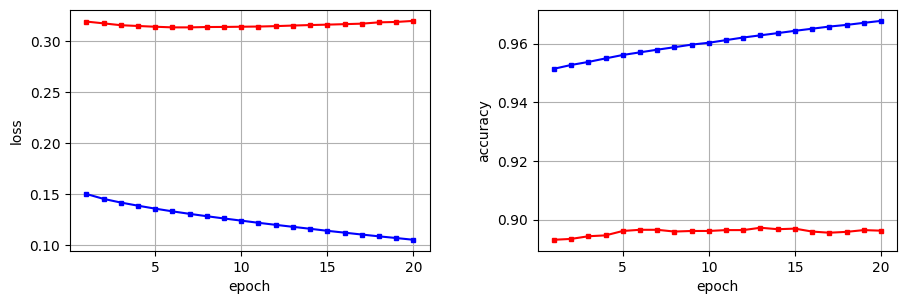

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s', markersize=3)
ax.plot(xx, H.history['val_loss'], color='r', marker='s', markersize=3)
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s', markersize=3)
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s', markersize=3);